# Recession Classification 
### Predicting Recessions Using Market Indicators
##### a study by James Beedle

Motivation: There are many ways to measure the American economy, and with this every economist has their favorite predictor of a recession. This study aims to examine some of these different indicators together in order to create a classification model that hopefully gives us a better idea of what different economic measures are associated with a recession. The end goal is to build a predictive model based on training data from previous recessions to more accurately predict future recessions. Having this kind of model will ideally provide enough notice of an economic downturn to allow a large firm to act defensively.

Data: The data used will all be pulled from the St.Louis Federal Reserve FRED data repository. This is my favorite reference because it freely gives troves of economic data from a trusted source in easily accessible formats. All of the predictors examined in this study will be quantitative, however a recession is defined as two consecutive quarters of negative economic growth as measured by a country's gross domestic product (GDP). Measures I will be examining are leverage, the Federal Funds Rate, inflation, a large stock market index, spread between long and short term treasury debt, future capex, and industrial orders. These all are measured quantitatively, and scaled quarterly. As a note, the recession indicator is pulled from the FED data, and not implied from GDP data.

Method: First, we are going to use two more familiar methods, Logistic and KNN to establish a baseline. After that we are going to explore support vector machines for classification to see which model does best and using what resources

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
import sklearn
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix as confusion_matrix
import sklearn.model_selection

In [2]:
cpi = pd.read_csv('TotalData.csv', index_col = 'Date')
cpi.head()

,CPI or Inflation,RecessionDates,FederalFundsRate,GrossDomesticProduct,Leverage,LongShortTreasurySpread,Will5000index,FutureCapex,Orders
Date,,,,,,,,,
1976-10-01,1.16212,0.0,4.874239,2.52921,-3.41759,0.367690,1.99501,41.266667,16.433333
1977-01-01,1.72315,0.0,4.660667,2.81113,-11.28028,-0.135155,-0.73350,37.933333,26.466667
1977-04-01,2.20215,0.0,5.157473,3.38225,-14.73983,-0.083968,0.49261,32.800000,25.433333
1977-07-01,1.43646,0.0,5.816413,3.04313,-25.28489,-0.433492,0.49020,30.100000,15.466667
1977-10-01,1.08932,0.0,6.511304,2.16179,-32.69231,-0.359929,-0.97561,33.800000,16.566667


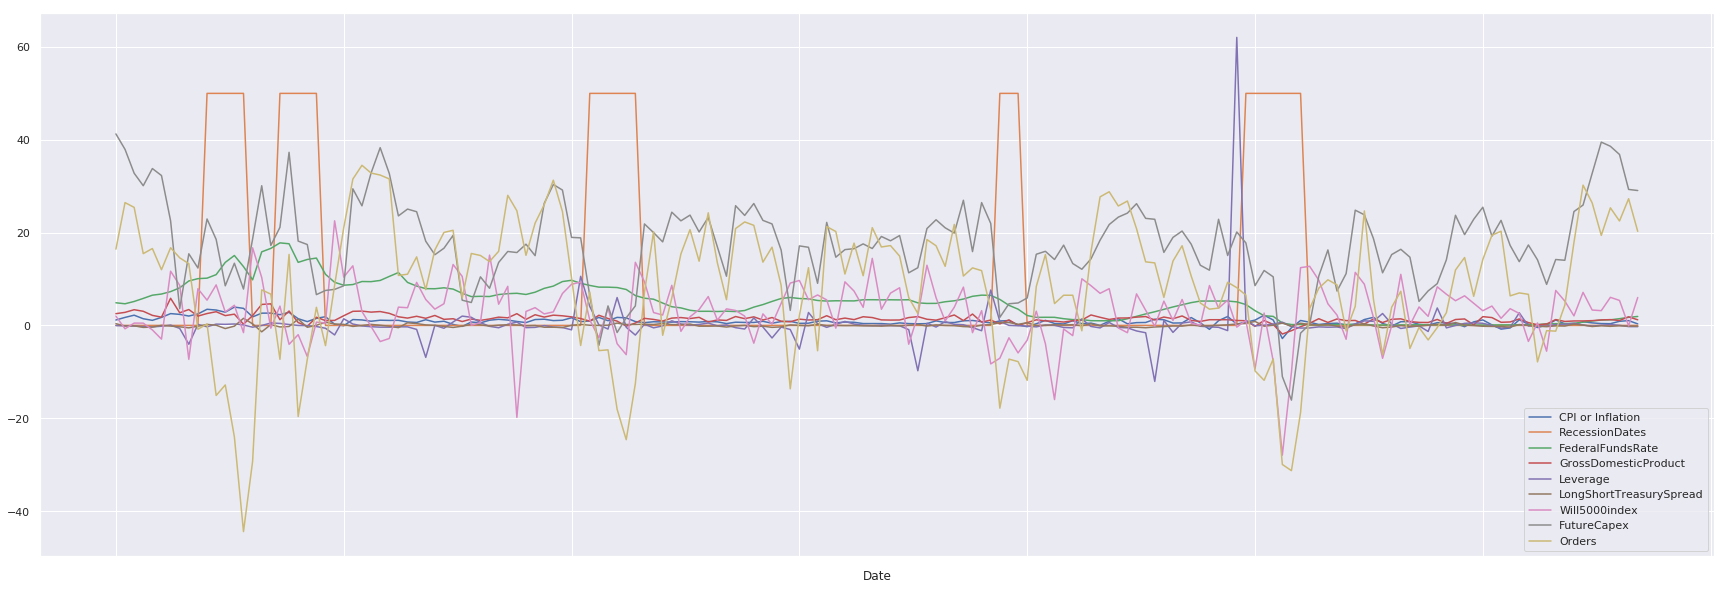

In [3]:
cpi['RecessionDates'] = cpi['RecessionDates'].values  * 50 # to predominantly show the recession
cpi['Leverage'] = cpi['Leverage'].values  / 100 # to not ruin the scale of the graph
plot1 = cpi.plot(figsize =[30, 10] )

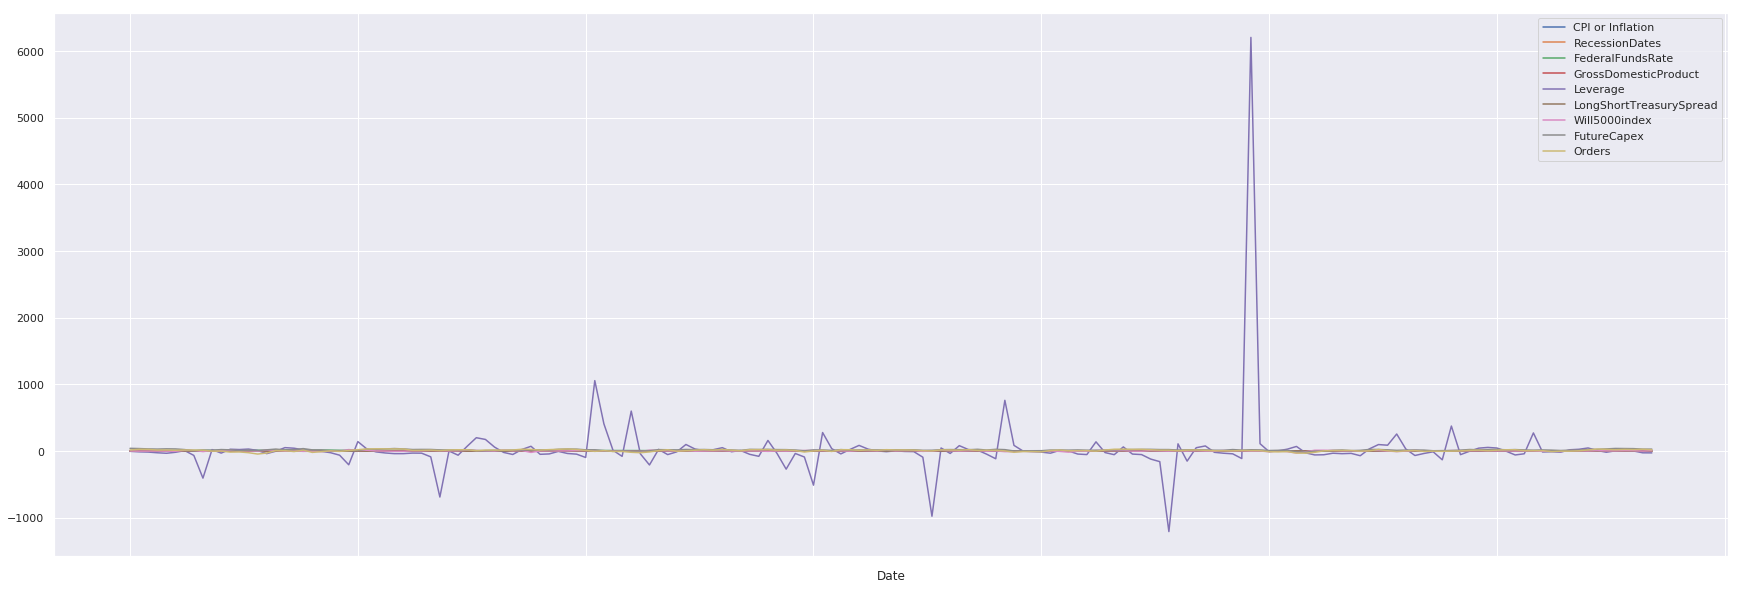

In [4]:
cpi['RecessionDates'] = cpi['RecessionDates'].values / 50
cpi['Leverage'] = cpi['Leverage'].values * 100
plot1 = cpi.plot(figsize =[30, 10] )

Exploratory Data Analysis:

The Data was provided from the FED FRED in CSV format. The scale is by percent change quarterly. Since each index have different scales, boiling everything down to percent allows us to see correlations better. The factors being examined are CPI or consumer price index (blue) that shows inflation. The orange line is a boolean indicator of a recession based on GDP. The Green line shows the federal funds rate. The Blue line shows the spread between 10 year treasury rate and 2 year treasury rate. The brown line shows the Will5000 which is an index of 5000 large and mid cap stocks. The red line shows GDP, and the purple line shows Leverage. It's a little crowded in the first 5 or so percentile.

There are some strong correlations represented in the data. We see that positive recession indicators are accompanied with a reduction in the stock market index, a negative long/short treasury spread, decreases in the CPI, and either a decline or a flattening of federal funds rate. Not all of these predictors occur for each recession.

So far the data has been transformed using aggregation into quarterly periods, as well as being percentage units as opposed to index units. I initially tried using the Leverage datapoint in my project, but it has a large spike that throws the graph off. This was scaled down by 10x to show the graph more clearly. I think during my regression, the recession dates boolean/dummy data and the leverage data will need to be scaled back. Other than this, most of the data is where I want it.

I already cleaned my data by truncating everything down to the same timeframe (quarterly) and on a common scale. Otherwise there are no NAN or any other bad data that requires cleaning. Any outliers are very important to the project. I believe that the negative yield and vastly increased leverage are going to be the most prominant indicators of a recession.

## Logistic Classification

In [5]:
recess_y = cpi['RecessionDates'].values
y,X = patsy.dmatrices("RecessionDates ~  FederalFundsRate + Leverage + LongShortTreasurySpread + Will5000index + Orders + FutureCapex", data = cpi)

lr = sklearn.linear_model.LogisticRegression(solver = 'liblinear')

recess_mod = lr.fit(X, y.ravel())

yhat = recess_mod.predict(X)
yhat_p = recess_mod.predict_proba(X) 

print(' Confusion Matrix:\n', sklearn.metrics.confusion_matrix(yhat, recess_y))

 Confusion Matrix:
 [[137   7]
 [  5  19]]


It looks like using logistic classification given these predictors has a fairly large training error. The model is able to predict a good amount of non recession cases (137 out of 142). As well as the recession cases, with  19 / 26 of the cases correctly predicted. 

Because we have a lot of cases where there is not a recession, but relatively very few cases of an actual recession we can try using KNN to get a better prediction rate. Below, I plotted graphs using different numbers of K and then using different numbers of training cases to see which variation of the model gave the best prediction.

## K Nearest Neighbors Classification

In [6]:
cpi.RecessionDates = pd.Categorical(cpi.RecessionDates)

ti_y = cpi.RecessionDates.cat.codes.astype('float')
ti_X = cpi[['FederalFundsRate', 'Leverage', 'LongShortTreasurySpread', 'Will5000index','Orders', 'FutureCapex' ]].values.astype('float')
scaled_X = sklearn.preprocessing.scale(ti_X,axis=0)
scale_y = sklearn.preprocessing.scale(ti_y,axis=0)


In [7]:
thenum = 80
ti_X_train, ti_X_test = ti_X[:thenum,],ti_X[:-thenum,]
ti_y_train, ti_y_test = ti_y[:thenum], ti_y[:-thenum]
scaled_X_train, scaled_X_test = scaled_X[:thenum,],scaled_X[:-thenum,]

k = 1

neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k, n_jobs=-1)
%time neigh.fit(ti_X_train, ti_y_train)

%time knn_hat = neigh.predict(ti_X_test)
knn_cm = sklearn.metrics.confusion_matrix(ti_y_test, knn_hat)
print('KNN(', k,') confusion matrix is = \n', knn_cm)
print('Success = ', knn_cm[1,1] / (knn_cm[1,0] + knn_cm[1,1]))
print(sklearn.metrics.classification_report(ti_y_test, knn_hat))

CPU times: user 1.09 ms, sys: 37 µs, total: 1.12 ms
Wall time: 916 µs
CPU times: user 6.26 ms, sys: 3.08 ms, total: 9.33 ms
Wall time: 105 ms
KNN( 1 ) confusion matrix is = 
 [[72  0]
 [ 0 16]]
Success =  1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        72
         1.0       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



In [8]:
thenum = 70
ti_X_train, ti_X_test = ti_X[:thenum,],ti_X[:-thenum,]
ti_y_train, ti_y_test = ti_y[:thenum], ti_y[:-thenum]
scaled_X_train, scaled_X_test = scaled_X[:thenum,],scaled_X[:-thenum,]

k = 1

neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k, n_jobs=-1)
%time neigh.fit(ti_X_train, ti_y_train)

%time knn_hat = neigh.predict(ti_X_test)
knn_cm = sklearn.metrics.confusion_matrix(ti_y_test, knn_hat)
print('KNN(', k,') confusion matrix is = \n', knn_cm)
print('Success = ', knn_cm[1,1] / (knn_cm[1,0] + knn_cm[1,1]))
print(sklearn.metrics.classification_report(ti_y_test, knn_hat))

CPU times: user 1.15 ms, sys: 1.12 ms, total: 2.27 ms
Wall time: 1.82 ms
CPU times: user 5.83 ms, sys: 2.38 ms, total: 8.2 ms
Wall time: 103 ms
KNN( 1 ) confusion matrix is = 
 [[79  2]
 [ 1 16]]
Success =  0.9411764705882353
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        81
         1.0       0.89      0.94      0.91        17

   micro avg       0.97      0.97      0.97        98
   macro avg       0.94      0.96      0.95        98
weighted avg       0.97      0.97      0.97        98



K Nearest Neighbors classified the last half of the recession data very well in most cases. Using K = 1 gave the best results for predicting the testing data.

Below, I am going to go through all combinations of k = 1,2,3,4 and training levels of 10 through 140 training samples of the array to see which gives the best model. 

In [9]:
def regressor(ti_X, ti_y, thenum,k):
    ti_X_train, ti_X_test = ti_X[:thenum,],ti_X[:-thenum,]
    ti_y_train, ti_y_test = ti_y[:thenum], ti_y[:-thenum]
    scaled_X_train, scaled_X_test = scaled_X[:thenum,],scaled_X[:-thenum,]
    neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k, n_jobs=-1)
    neigh.fit(ti_X_train, ti_y_train)
    knn_hat = neigh.predict(ti_X_test)
    knn_cm = sklearn.metrics.confusion_matrix(ti_y_test, knn_hat)
    return(knn_cm[1,1] / (knn_cm[1,0] + knn_cm[1,1]))

In [10]:
exes = np.arange(10,len(ti_X)-30)
ks = 5
y_list = []

for knum in np.arange(1, ks):
    y_suc = np.zeros(len(ti_X)-10)
    for num in exes:
        y_suc[num-10] = regressor(ti_X, ti_y, num, knum)
    y_list.append(y_suc)    
    
exes = np.arange(10,len(ti_X)) 

k=1


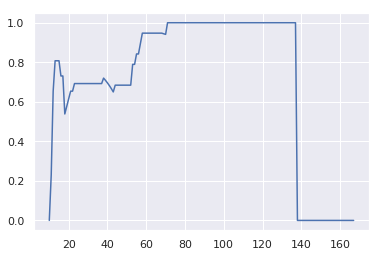

In [11]:
plt0 = plt.plot(exes, y_list[0])
print( "k=1")

k=2


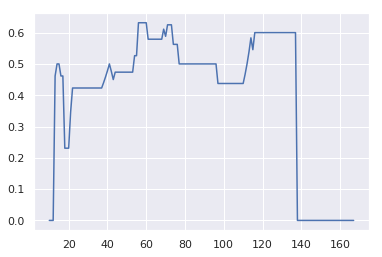

In [12]:
plt1 = plt.plot(exes, y_list[1])
print( "k=2")

k=3


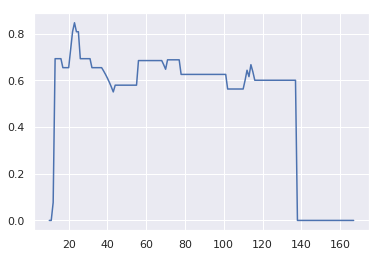

In [13]:
plt2 = plt.plot(exes, y_list[2])
print( "k=3")

k=4


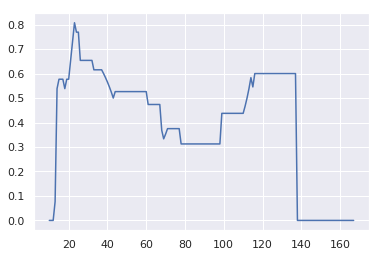

In [14]:
plt3 = plt.plot(exes, y_list[3])
print( "k=4")

The KNN model with K = 1 and a training subset of roughly 80 predicts perfectly on the test data. K = 3 gave a fairly good train/test overall,
and performed second best. k=4 had a really good showing only using 22 test cases which is impressive

## Support Vector Machines Model
The model I decided to learn about and implement was SVM, because it sounds interesting and is a widely recognized method of classification. SVM is a supervised training model similar to KNN. the SVM is a non probablistic classifier, but can be used with a method called Platt Scaling to use the SVM in a probablistic setting. SVM's are used a lot for clustering and unsupervised learning, but I am interested in exploring it for my supervised study .

In [15]:
thenum= 60

X_train, X_test = X[:thenum,],X[:-thenum,]
y_train, y_test = y[:thenum], y[:-thenum]

clf = svm.SVC(gamma = 'auto')
%time clf.fit(X_train,y_train.ravel())
%time yhat = clf.predict(X_test)
print(' Confusion Matrix:\n', sklearn.metrics.confusion_matrix(yhat, y_test))

CPU times: user 2.48 ms, sys: 1.21 ms, total: 3.69 ms
Wall time: 1.08 ms
CPU times: user 1.74 ms, sys: 444 µs, total: 2.19 ms
Wall time: 639 µs
 Confusion Matrix:
 [[89  3]
 [ 0 16]]


The results for the SVM classification are good! It was able to accurately classify all but a few recessions in the testing data. It did not miss any of the non recession quarters. The speed is a bit slower then KNN which docks it some points, but overall the performance is better than logistic.